# **How house attributes influence the sale price**

## Objectives

**Generate content to satisfy Business requirement 1**:
* Determine how features are correlated to the target, and thus their significance in determining the sale price.

## Inputs

* house prices dataset: outputs/datasets/collection/house_prices.csv

## Outputs


## Conclusions


---

## Change working directory

Working directory changed to its parent folder.

In [4]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage_housing_issues'

In [2]:
os.chdir(os.path.dirname(current_dir))
os.getcwd()

'/workspace/heritage_housing_issues'

---

## Load house prices dataset

In [8]:
import pandas as pd

house_prices_df = pd.read_csv(filepath_or_buffer='outputs/datasets/collection/house_prices.csv')
house_prices_df.dtypes

1stFlrSF           int64
2ndFlrSF         float64
BedroomAbvGr     float64
BsmtExposure      object
BsmtFinSF1         int64
BsmtFinType1      object
BsmtUnfSF          int64
EnclosedPorch    float64
GarageArea         int64
GarageFinish      object
GarageYrBlt      float64
GrLivArea          int64
KitchenQual       object
LotArea            int64
LotFrontage      float64
MasVnrArea       float64
OpenPorchSF        int64
OverallCond        int64
OverallQual        int64
TotalBsmtSF        int64
WoodDeckSF       float64
YearBuilt          int64
YearRemodAdd       int64
SalePrice          int64
dtype: object

---

## Dealing with missing data

Discover columns with missing data

In [9]:
missing_data_df = house_prices_df.loc[:, house_prices_df.isna().any()]
print(missing_data_df.info())
house_prices_numeric_df = house_prices_df.select_dtypes(exclude=['object']).drop(['SalePrice'], axis=1)
print(house_prices_numeric_df.columns)
house_prices_non_numeric_df = house_prices_df.select_dtypes(include='object')
house_prices_non_numeric_df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   2ndFlrSF       1374 non-null   float64
 1   BedroomAbvGr   1361 non-null   float64
 2   BsmtFinType1   1346 non-null   object 
 3   EnclosedPorch  136 non-null    float64
 4   GarageFinish   1298 non-null   object 
 5   GarageYrBlt    1379 non-null   float64
 6   LotFrontage    1201 non-null   float64
 7   MasVnrArea     1452 non-null   float64
 8   WoodDeckSF     155 non-null    float64
dtypes: float64(7), object(2)
memory usage: 102.8+ KB
None
Index(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtUnfSF',
       'EnclosedPorch', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'LotArea',
       'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond',
       'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')


Index(['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'], dtype='object')

**Impute missing values in numeric columns**.  
Want to choose an impute method that does not distort the distribution significantly, whilst preserving any existing correlations.
With this in mind the KNNImputer is employed with 5 nearest neighbours used.

1stFlrSF         0
2ndFlrSF         0
BedroomAbvGr     0
BsmtFinSF1       0
BsmtUnfSF        0
EnclosedPorch    0
GarageArea       0
GarageYrBlt      0
GrLivArea        0
LotArea          0
LotFrontage      0
MasVnrArea       0
OpenPorchSF      0
OverallCond      0
OverallQual      0
TotalBsmtSF      0
WoodDeckSF       0
YearBuilt        0
YearRemodAdd     0
dtype: int64


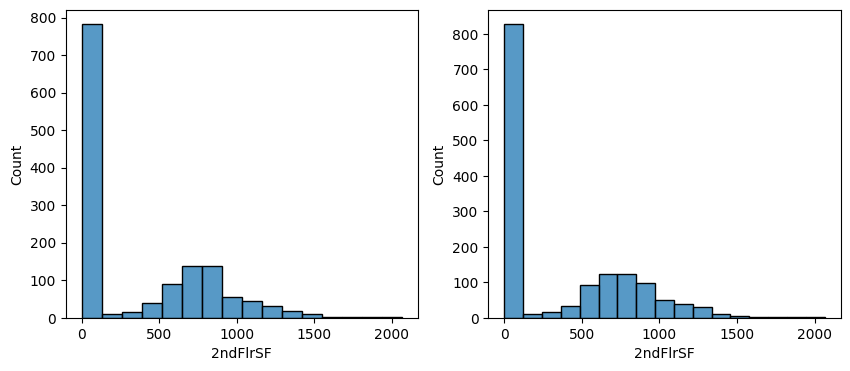

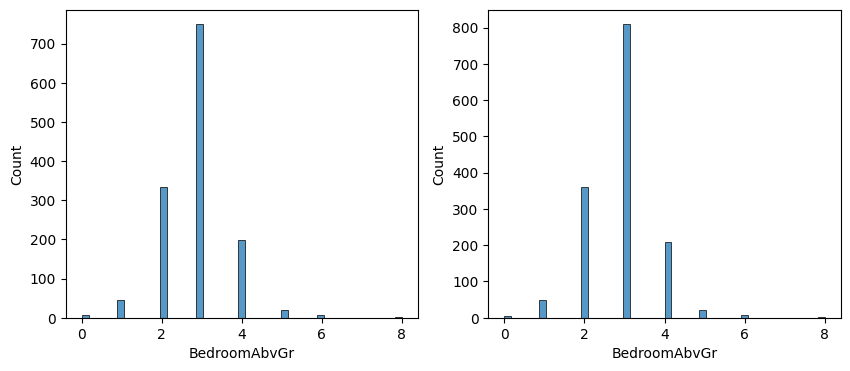

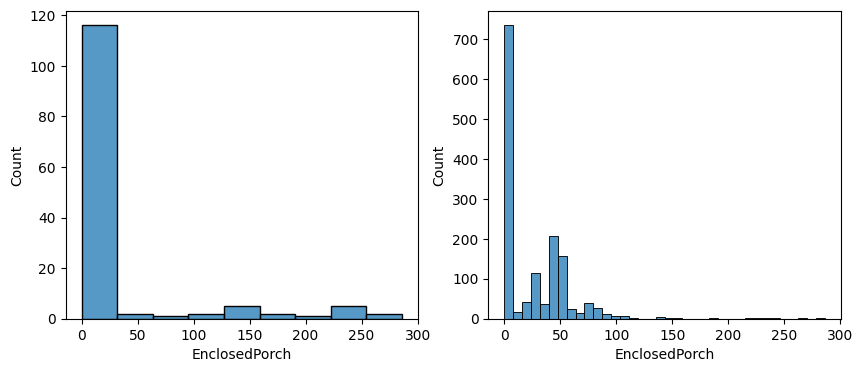

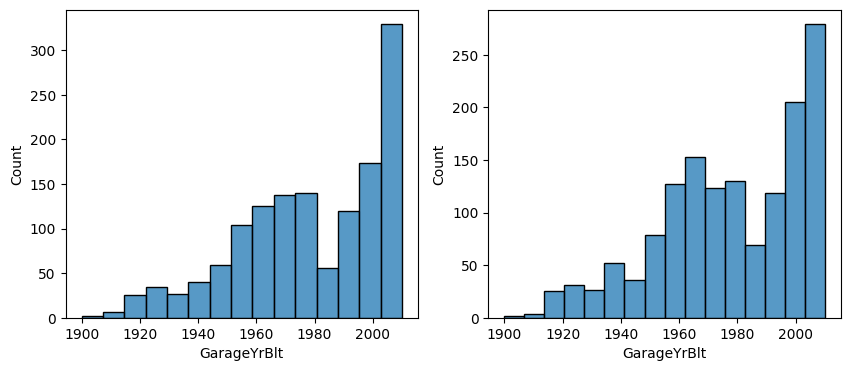

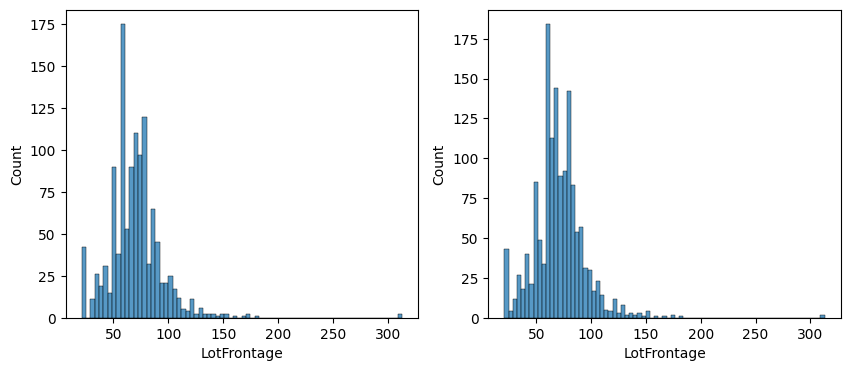

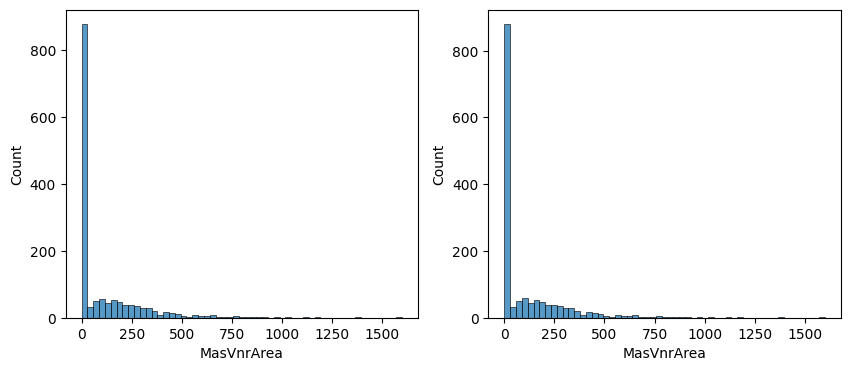

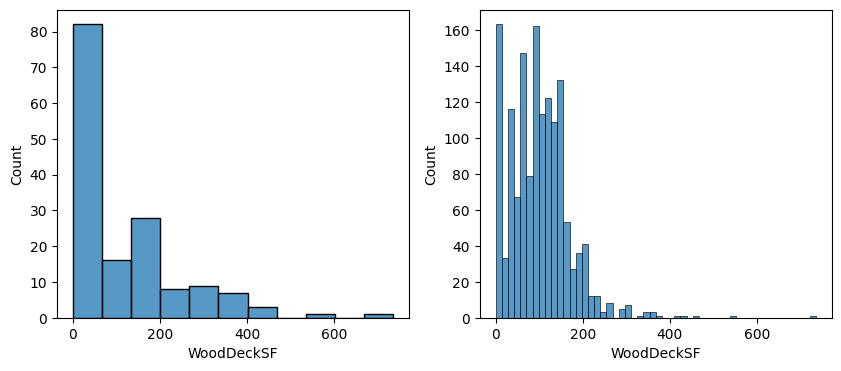

In [10]:
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt

# plotting distributions for numeric variables with missing data
counter = 0
imputed_columns = []
while counter < len(house_prices_numeric_df.columns):
    if house_prices_numeric_df.iloc[:, counter].name in missing_data_df.columns:
        fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
        sns.histplot(x=house_prices_numeric_df.iloc[:, counter], ax=ax[0])
        imputed_columns.append(house_prices_numeric_df.iloc[:, counter].name)
    counter += 1

# Imputing the missing values for required columns
imputer = KNNImputer()
imputer.set_output(transform='pandas')
house_prices_numeric_df = imputer.fit_transform(house_prices_numeric_df)
print(house_prices_numeric_df.isna().sum())
house_prices_df[house_prices_numeric_df.columns.values] = house_prices_numeric_df

for col in ['BedroomAbvGr','GarageYrBlt','OverallCond','OverallQual','YearBuilt', 'YearRemodAdd']:
    house_prices_numeric_df[col] = house_prices_numeric_df[col].round()

# plotting distributions after imputation on same figures, for visual comparison
for fig in plt.get_fignums():
    sns.histplot(x=house_prices_numeric_df[imputed_columns[fig - 1]], ax=plt.figure(fig).get_axes()[1])


Inspection of the above figures showing the variable distributions before and after imputation, shows that apart from the 'EnclosedPorchSF' and 'WoodDeckSF' variables,
there is no noticeable change to the distribution shapes. In the case of the EnclosedPorchSF variable, a large quantity of data was missing,
so the somewhat noticeable change is inevitable; the same is true for the WoodDeckSF variable.

**Impute missing values in non-numeric columns**.  
In the absence of a viable distance metric, and considering the fact that only a small amount of data is missing, the KNNImputer was not used. Instead the more
simple method for filling the values by cycling through the possible values was used.

Index(['BsmtFinType1', 'GarageFinish'], dtype='object')


1stFlrSF         0
2ndFlrSF         0
BedroomAbvGr     0
BsmtExposure     0
BsmtFinSF1       0
BsmtFinType1     0
BsmtUnfSF        0
EnclosedPorch    0
GarageArea       0
GarageFinish     0
GarageYrBlt      0
GrLivArea        0
KitchenQual      0
LotArea          0
LotFrontage      0
MasVnrArea       0
OpenPorchSF      0
OverallCond      0
OverallQual      0
TotalBsmtSF      0
WoodDeckSF       0
YearBuilt        0
YearRemodAdd     0
SalePrice        0
dtype: int64

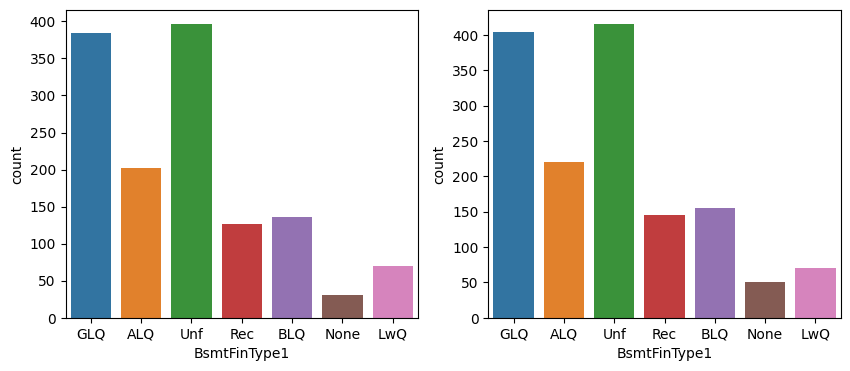

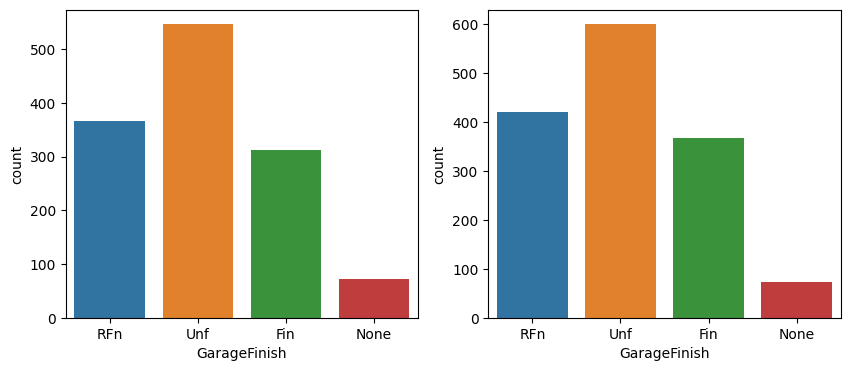

In [11]:
missing_data_non_numeric_df = missing_data_df.select_dtypes(include='object')
print(missing_data_non_numeric_df.columns)

# plotting the variable distributions before imputation
counter = 0
imputed_columns = []
while counter < len(missing_data_non_numeric_df.columns):
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
    sns.countplot(x=missing_data_non_numeric_df.iloc[:, counter], ax=ax[0])
    imputed_columns.append(missing_data_non_numeric_df.iloc[:, counter].name)
    counter += 1

# imputing the missing values
for col in imputed_columns:
    number_of_nans = house_prices_df[col].loc[(house_prices_df[col].isna() == True)].size
    unique_values = house_prices_df[col].unique()
    index_no = 0
    while number_of_nans > 0:
        if index_no + 1 >= unique_values.size:
            index_no = 0
        house_prices_df[col].fillna(value=unique_values[index_no], limit=1, inplace=True)
        index_no += 1
        number_of_nans = house_prices_df[col].loc[(house_prices_df[col].isna() == True)].size

# plotting the distributions on the same figures after imputation for comparison
for fig in plt.get_fignums():
    sns.countplot(x=house_prices_df[imputed_columns[fig - 1]], ax=plt.figure(fig).get_axes()[1])
          
house_prices_df.isna().sum()

Can see from the above figures that there are no significant changes in the distribution shapes.